In [1]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
# from keras.optimizers.layers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard

import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adam, Nadam

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)

Python:  3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
pandas:  1.3.5
numpy:  1.21.6
seaborn:  0.11.2
matplotlib:  3.2.2
sklearn:  1.0.2
Keras:  2.8.0
Tensorflow:  2.8.0


In [2]:
# Mount to google drive if using colab 
using_colab = 'yes'

if using_colab == 'yes':
  # mount google drive
  from google.colab import drive
  drive.mount('/content/drive')

  # change working director
  %cd "/content/drive/MyDrive/capstone"

# Load dataset
df_appl_until_march = pd.read_csv('appl_until_march.csv')
df_appl_april = pd.read_csv("appl_april.csv")
merged_df = pd.DataFrame()

print('Shape:' , df_appl_until_march.shape[0])
print('Head:')
print(df_appl_until_march.head(5))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/capstone
Shape: 10400
Head:
         Date      Open      High       Low     Close  Adj Close    Volume
0  1981-01-02  0.154018  0.155134  0.154018  0.154018   0.120391  21660800
1  1981-01-05  0.151228  0.151228  0.150670  0.150670   0.117774  35728000
2  1981-01-06  0.144531  0.144531  0.143973  0.143973   0.112539  45158400
3  1981-01-07  0.138393  0.138393  0.137835  0.137835   0.107741  55686400
4  1981-01-08  0.135603  0.135603  0.135045  0.135045   0.105560  39827200


In [3]:
df_appl_until_march = df_appl_until_march.drop('Open', axis=1).drop('High',
 axis=1).drop('Low', axis=1).drop('Adj Close',axis=1).drop('Volume',axis=1)

df_appl_until_march.head()

,Date,Close
0,1981-01-02,0.154018
1,1981-01-05,0.150670
2,1981-01-06,0.143973
3,1981-01-07,0.137835
4,1981-01-08,0.135045


         Date     Close
0  1981-01-02  0.154018
1  1981-01-05  0.150670
2  1981-01-06  0.143973


Text(0.5, 1.0, 'Time Series of Close price by date')

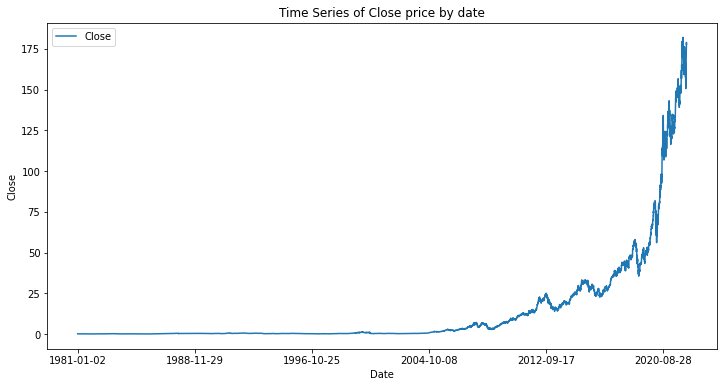

In [4]:
print(df_appl_until_march.head(3))
df_appl_until_march.shape
df_appl_until_march.plot(x='Date', y='Close', figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Time Series of Close price by date')

In [5]:
df_appl_until_march.Close.describe()

count    10400.000000
mean        14.046659
std         30.369018
min          0.049107
25%          0.283342
50%          0.471540
75%         14.263482
max        182.009995
Name: Close, dtype: float64

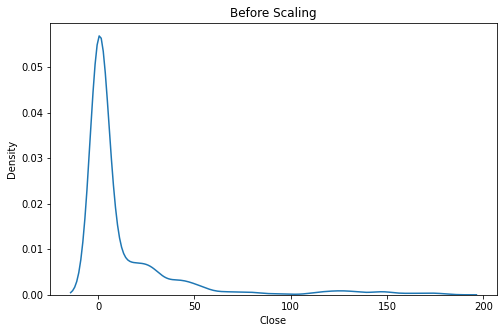

In [6]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df_appl_until_march['Close'], ax=ax1)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df_appl_until_march['scaled_Close'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df_appl_until_march['Close'])),columns=['Close'])
print('Shape:' , df_appl_until_march.shape[0])
df_appl_until_march.head(5)

Shape: 10400


,Date,Close,scaled_Close
0,1981-01-02,0.154018,0.000577
1,1981-01-05,0.150670,0.000558
2,1981-01-06,0.143973,0.000521
3,1981-01-07,0.137835,0.000488
4,1981-01-08,0.135045,0.000472


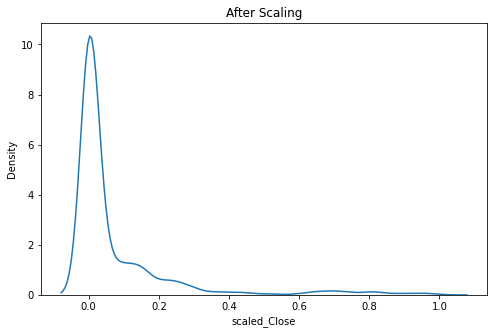

In [8]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After Scaling')
sns.kdeplot(df_appl_until_march['scaled_Close'], ax=ax1)

In [9]:
time_steps = 40
metric = 'mean_absolute_error'

model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape=(time_steps, 1), return_sequences=True))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 32)            4352      
                                                                 
 dense (Dense)               (None, 40, 1)             33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# Split the sequence into a tumbling window of sub-seuences of length 48

sequence = np.array(df_appl_until_march['scaled_Close'])
print(sequence)
time_steps = 40
samples = len(sequence)
trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
print(sequence_trimmed.shape)

[5.76557969e-04 5.58158410e-04 5.21353798e-04 ... 9.64772710e-01
 9.83238222e-01 9.76698339e-01]
10400 260
(260, 40, 1)


In [11]:
training_dataset = sequence_trimmed
training_dataset.shape

(260, 40, 1)

In [12]:
# Train model for 20 epochs

training_dataset = sequence_trimmed
print("training_dataset: ", training_dataset.shape)

batch_size=32
epochs=20

model.fit(x=training_dataset, y=training_dataset,
                       batch_size=batch_size, epochs=epochs,
                       verbose=1, validation_data=(training_dataset, training_dataset))

training_dataset:  (260, 40, 1)
Epoch 1/20
9/9 [==============================] - 6s 174ms/step - loss: 0.4394 - mean_absolute_error: 0.4394 - val_loss: 0.4301 - val_mean_absolute_error: 0.4301
Epoch 2/20
9/9 [==============================] - 0s 56ms/step - loss: 0.4225 - mean_absolute_error: 0.4225 - val_loss: 0.4071 - val_mean_absolute_error: 0.4071
Epoch 3/20
9/9 [==============================] - 0s 39ms/step - loss: 0.3900 - mean_absolute_error: 0.3900 - val_loss: 0.3519 - val_mean_absolute_error: 0.3519
Epoch 4/20
9/9 [==============================] - 0s 42ms/step - loss: 0.2926 - mean_absolute_error: 0.2926 - val_loss: 0.1861 - val_mean_absolute_error: 0.1861
Epoch 5/20
9/9 [==============================] - 0s 39ms/step - loss: 0.1534 - mean_absolute_error: 0.1534 - val_loss: 0.1299 - val_mean_absolute_error: 0.1299
Epoch 6/20
9/9 [==============================] - 0s 37ms/step - loss: 0.1236 - mean_absolute_error: 0.1236 - val_loss: 0.1166 - val_mean_absolute_error: 0.1166
E

In [13]:
# Predict test dataset that was split into subseqeunecs
# of the same length (time_steps) as the training datasets.

import math
from sklearn.metrics import mean_squared_error

sequence = np.array(df_appl_until_march['scaled_Close'])
print(sequence)
time_steps = 40
samples = len(sequence)
trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
print(sequence_trimmed.shape)

testing_dataset = sequence_trimmed
print("testing_dataset: ", testing_dataset.shape)

testing_pred = model.predict(x=testing_dataset)
print("testing_pred: ", testing_pred.shape)

testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]), testing_dataset.shape[2])
print("testing_dataset: ", testing_dataset.shape)

testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print("testing_pred: ", testing_pred.shape)
errorsDF = testing_dataset - testing_pred
print(errorsDF.shape)

# Compute rmse
rmse = math.sqrt(mean_squared_error(testing_dataset, testing_pred))
print('Test RMSE: %.3f' % rmse)

[5.76557969e-04 5.58158410e-04 5.21353798e-04 ... 9.64772710e-01
 9.83238222e-01 9.76698339e-01]
10400 260
(260, 40, 1)
testing_dataset:  (260, 40, 1)
testing_pred:  (260, 40, 1)
testing_dataset:  (10400, 1)
testing_pred:  (10400, 1)
(10400, 1)
Test RMSE: 0.194


In [14]:
print(testing_dataset.shape)

(10400, 1)


In [15]:
# RMSE is 0.107 which is quite low, and this is also evident 
# from the low loss from the training phase after 20 epochs.

# Now we can use the predicted dataset and the test dataset to compute 
# the difference as diff, which is then passed through vector norms. 
# Calculating the length or magnitude of vectors is often required directly 
# as a regularization method in machine learning. We can then sort 
# the scores/diffs and use a curoff value to pick the threshold. 
# This obviously can change as per the paramters you choose, particularly 
# the cutoff value (which is 0.99).

# based on cutoff after sorting errors
dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

scores =dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.999 * len(scores))
print(cutoff)
#print(scores[cutoff:])
threshold= scores[cutoff]
print(threshold)

(10400,)
10389
0.9644763853449119


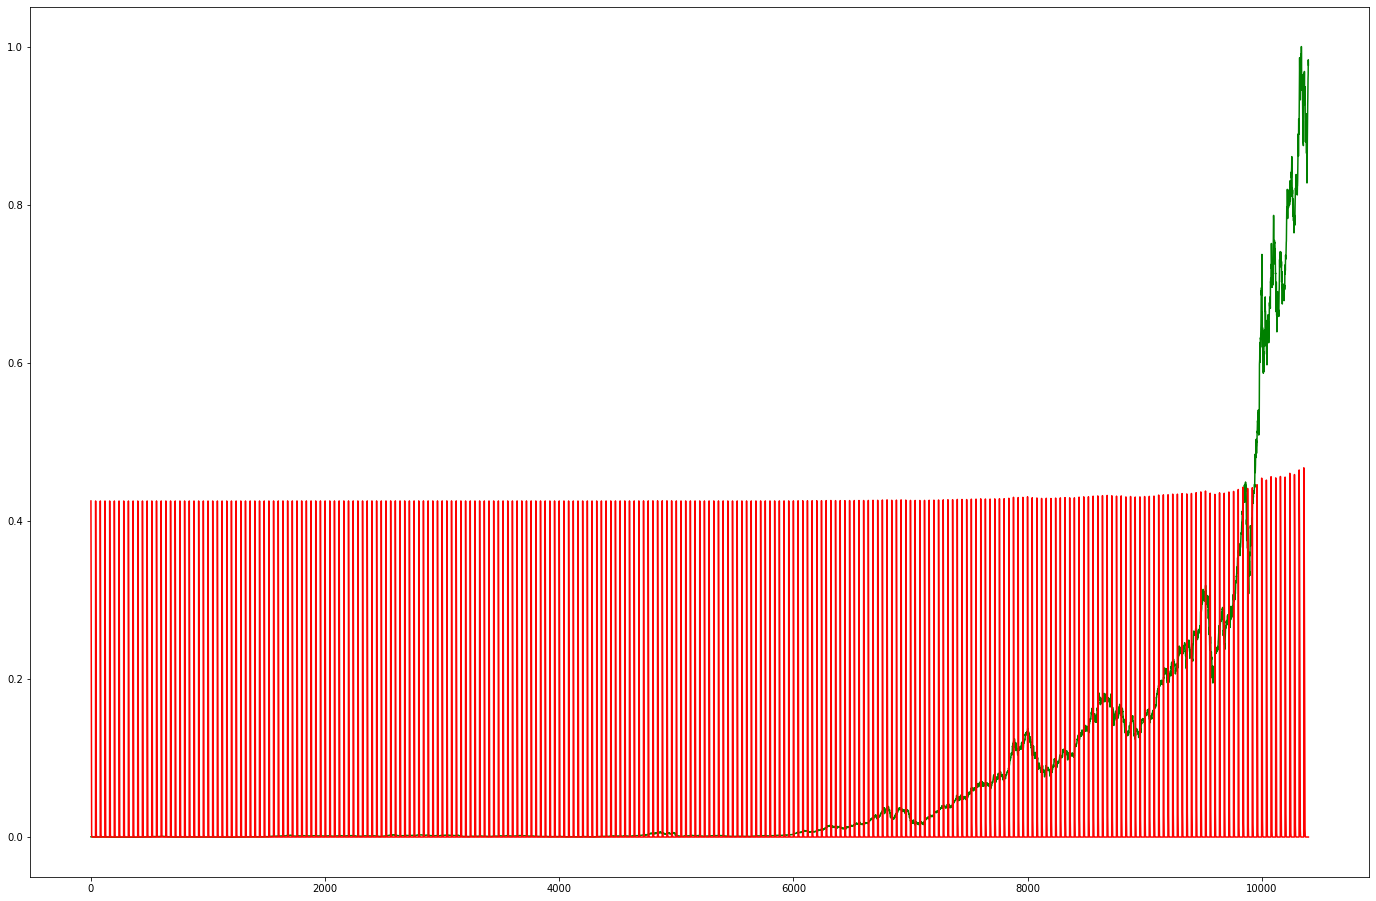

In [16]:
# I got 0.965 as the threshold. Anything above will be considered an anomaly. 
# We plot the testing dataset (Green) and the correspindong predicted data set (red)

plt.figure(figsize=(24,16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color='red')

In [17]:
#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=[]
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)
    

In [18]:
print(len(df_appl_until_march['Date']))
print(len(df_appl_until_march['Close']))
print(len(error))
print(len(y_label))

10400
10400
10400
10400


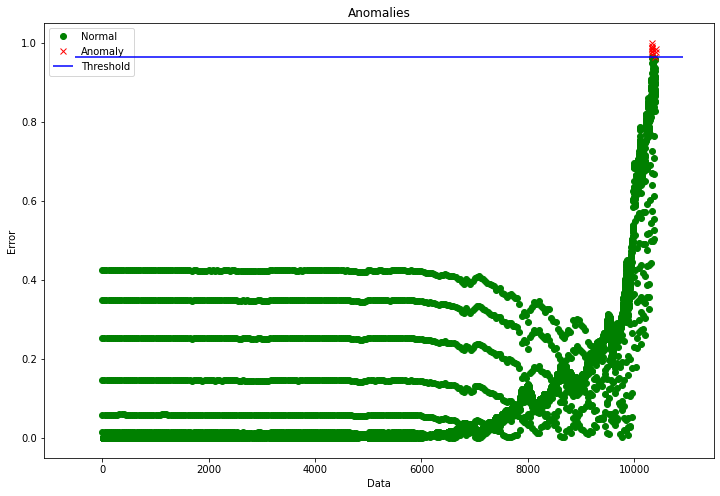

In [19]:
groupsDF = pd.DataFrame({'error': error, 'true': y_label}).groupby('true')

figure, axes = plt.subplots(figsize=(12, 8))

for name, group in groupsDF:
    axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
        color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
axes.legend()
        
plt.title("Anomalies")
plt.ylabel("Error")
plt.xlabel("Data")
plt.show()

In [20]:
adf = pd.DataFrame({'Date': df_appl_until_march['Date'], 'observation': df_appl_until_march['Close'],
                    'error': error, 'anomaly': y_label})
adf.head(5)

,Date,observation,error,anomaly
0,1981-01-02,0.154018,0.424746,0
1,1981-01-05,0.150670,0.349203,0
2,1981-01-06,0.143973,0.253206,0
3,1981-01-07,0.137835,0.146685,0
4,1981-01-08,0.135045,0.059250,0


In [21]:
print(len(df_appl_until_march['Date']))
print(len(df_appl_until_march['Close']))
print(len(error))
print(len(y_label))

10400
10400
10400
10400


Text(0.5, 1.0, 'Time Series of value by date time')

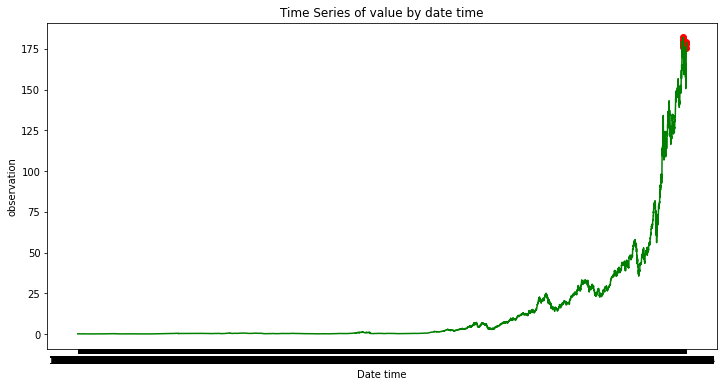

In [24]:
figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Date'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Date'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')